# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: 
Fecha de entrega: 2 de octubre de *2020*

In [1]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

In [2]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos

corrector = AutoCorrect(host='cc6204.dcc.uchile.cl', port=443)

# anota el token que te daremos en u-cursos

token = ']ye/Ox;nsz'

Connection stablished


# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [3]:
# Sigmoid(T)
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

# Tanh(T)
def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def relu(T):
  T = torch.tensor(T)
  zeros = torch.zeros_like(T)
  return torch.max(T,zeros)

def swish(T, beta):
  T = torch.tensor(T)
  return T * sig(T*beta)

def celu(T, alpha):
  T = torch.tensor(T)
  import math
  def celu_i(x):
    '''
    Aux function
    '''
    if x >= 0:
      return x
    else:
      return alpha*(math.exp(x/alpha)-1)

  return T.apply_(celu_i)

In [4]:
# correccion
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)


# probablemente quieras convertr los variables test_* a un tensor, ya que por defecto son listas

corrector.sumbit(homework=1, question="1a", test=1, token=token, answer=relu(test_relu))
corrector.sumbit(homework=1, question="1a", test=2, token=token, answer=swish(test_swish, swish_par))
corrector.sumbit(homework=1, question="1a", test=3, token=token, answer=celu(test_celu, celu_par))

Correct Test!
Correct Test!
Correct Test!


## 1b) Softmax

(La demostración puedes entregarla en otro archivo o incluirla directamente acá)

---



In [5]:
# Tu código acá

def softmax(T, dim, estable=True):
  T = torch.tensor(T)
  if estable:
    exp_i = torch.exp(T - torch.max(T))
    softm = torch.tensor(exp_i/torch.sum(exp_i, dim, keepdim=True))
    return softm
  else: 
    exp_i = torch.exp(T)
    softm = torch.tensor(exp_i/torch.sum(exp_i, dim, keepdim=True))
    return softm

In [6]:
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
corrector.sumbit(homework=1, question="1b", test=1, token=token, answer=softmax(test_softmax, dim=_dim))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Correct Test!


# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [7]:
class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    # capa de entrada
    # capa oculta
    for i, hidden_size in enumerate(l_h):
      if i == 0:
        self.hidden_layers = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(F, hidden_size))])
      else:  
        self.hidden_layers.append(torch.nn.Parameter(torch.rand(l_h[i-1], hidden_size)))  
    # self.hidden_layers = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(hidden_size)) for hidden_size in l_h])
    # baias:
    self.baias = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(hidden_size)) for hidden_size in l_h])
    # funciones de activacion
    self.activation = l_a
    # capa salida
    self.output_layer = torch.nn.Parameter(torch.rand(l_h[i],C))
    # Baias output layer
    self.output_bias = torch.nn.Parameter(torch.zeros(C))
  
  def resumen(self):
    # usa self.parameters() o self.named_parameters()
    return self.named_parameters()

  def load_parameters(self, W, B, U, C):
    for i, layer in enumerate(self.hidden_layers):
      layer.data = (W[i])
    
    for i, baias in enumerate(self.baias):
      baias.data = (B[i])
    
    self.output_bias.data = (C)
    self.output_layer.data = (U)
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    h = x
    for i, F in enumerate(self.activation):
      h = F(h @ self.hidden_layers[i] +  self.baias[i])

    out = softmax(h @ self.output_layer + self.output_bias, -1 ,  estable = True)
    return out

In [8]:
#instanciemos una red y veamos el resumen:
red_neuronal = FFNN(300,[50,30],[relu,sig],10)
red_neuronal.resumen

<bound method FFNN.resumen of FFNN(
  (hidden_layers): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 300x50]
      (1): Parameter containing: [torch.FloatTensor of size 50x30]
  )
  (baias): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 50]
      (1): Parameter containing: [torch.FloatTensor of size 30]
  )
)>

## 2c) Moviendo los parámetros entre dispositivos

In [9]:
# Tu código acá
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
red_neuronal.to(device)

cuda:0


FFNN(
  (hidden_layers): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 300x50 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 50x30 (GPU 0)]
  )
  (baias): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 50 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 30 (GPU 0)]
  )
)

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

In [10]:
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = datasets.MNIST(root='./data',
                             train=False,
                             download=True,
                             transform=ToTensor())
print('Cantidad total de datos:',len(dataset))

Cantidad total de datos: 10000


## 3b) Cargando los parámetros pre-entrenados

In [11]:
import os.path 
# Descargamos solo una vez los pesos:
if os.path.exists('/content/U.txt'):
  print('pesos ya descargados')
else:
  # U.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/U.txt
  # W1.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W1.txt
  # W2.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W2.txt
  # b1.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b1.txt
  # b2.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b2.txt
  # c.txt
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/c.txt


pesos ya descargados


In [12]:
from numpy import loadtxt
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
U = torch.from_numpy(loadtxt('U.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
C = torch.from_numpy(loadtxt('c.txt')).float()

In [13]:
modelo = FFNN(784,[32,16],[relu,relu],10)
print(modelo)

FFNN(
  (hidden_layers): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 784x32]
      (1): Parameter containing: [torch.FloatTensor of size 32x16]
  )
  (baias): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 32]
      (1): Parameter containing: [torch.FloatTensor of size 16]
  )
)


In [14]:
for param in modelo.parameters():
  param.requires_grad = False
# cargamos los pesos
modelo.load_parameters([W1,W2],[b1,b2], U, C)

In [15]:
# Comprobamos que se transfieran los pesos de C:
print(modelo.output_bias)
print(C)

Parameter containing:
tensor([-0.1841,  0.1299,  0.0363, -0.1974,  0.0875,  0.1237, -0.2129, -0.1553,
        -0.0097,  0.1864])
tensor([-0.1841,  0.1299,  0.0363, -0.1974,  0.0875,  0.1237, -0.2129, -0.1553,
        -0.0097,  0.1864])


## 3c) Calcula la predicción de un ejemplo al azar

Vector output =  tensor([6.2676e-10, 1.0951e-05, 5.1737e-05, 9.9982e-01, 1.0506e-08, 2.5756e-05,
        3.9574e-10, 9.4697e-08, 9.3332e-05, 6.9399e-07])
Etiqueta imagen =  3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


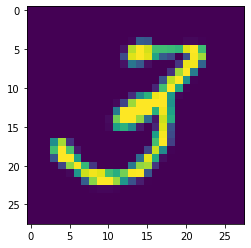

In [16]:
# Tu código aca
import random
import matplotlib.pyplot as plt
cpu = 'cpu'
modelo.to(cpu)
idx = random.randint(0,len(dataset))
T, l = dataset[idx]
img = T.view(28,28).numpy()
print("Vector output = ", modelo.forward(T.reshape(784)))
print("Etiqueta imagen = ", l)
plt.imshow(img)

## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [17]:
# Acá tu código
from torch.utils.data import DataLoader
def accuracy(y_hat_b, yb):    
    preds = torch.argmax(y_hat_b,dim=1)
    counts = (preds == yb)*1.0    
    return torch.mean(counts)

def calcula_acierto(red, dataset, batch_size=100, device='cuda:0'):  
  dataloader = DataLoader(dataset, batch_size)
  red.to(device)
  acc = []
  for i, (x, y) in enumerate(dataloader):
    y_hat = red(x.view(-1,784).to(device))
    acc.append(accuracy(y_hat.to(cpu), y.to(cpu)))

  return sum(acc)/len(acc)

In [18]:
calcula_acierto(modelo, dataset, 100, device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


tensor(0.9612)

### Corrección red

In [19]:
# Tests del API del curso
from torch.utils.data import Subset
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

cpu = 'cpu'
# Modelo con los parámetros pre-entrenados para MNIST
your_network = modelo.to(cpu)

# Montar el `test_set` en un tensor de (N, 28*28) usando DataLoader
X = list(DataLoader(test_set, batch_size=len(test_set)))[0][0].view(-1, 28*28)

# Almacenar el resultado en un puro tensor de (N,1)
result = torch.argmax(your_network(X), dim=1)

corrector.sumbit(homework=1, question="network", test=1, token=token, answer=result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Correct Test!


## 3e) Opcional: Muestra los casos en donde la red se equivoca

In [20]:
# Acá tu código

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [21]:
# Acá tu código